# Value at Risk (VaR) - Parametric Method

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set time from to a certain number of years

In [ ]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

# Create a list of tickers

In [ ]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

# Download the daily adjusted close prices for the tickers

In [ ]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(tickers, start = startDate, end = endDate, auto_adjust = False)
    adj_close_df = data['Adj Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [ ]:
print(adj_close_df)

Ticker            BND         GLD         QQQ         SPY         VTI
Date                                                                 
2010-06-14  52.309723  119.599998   39.717060   83.218742   42.766830
2010-06-15  52.218628  120.989998   40.782234   85.110947   43.729088
2010-06-16  52.342300  120.330002   40.948120   85.080551   43.683262
2010-06-17  52.485439  121.900002   41.079090   85.217331   43.759632
2010-06-18  52.465916  122.830002   41.113190   85.309731   43.790173
...               ...         ...         ...         ...         ...
2025-06-02  72.370003  311.670013  523.210022  592.710022  291.359985
2025-06-03  72.290001  308.910004  527.299988  596.090027  293.369995
2025-06-04  72.739998  310.899994  528.770020  595.929993  293.339996
2025-06-05  72.599998  309.329987  524.789978  593.049988  291.720001
2025-06-06  72.209999  305.179993  529.919983  599.140015  295.119995

[3770 rows x 5 columns]


# Calculate the daily log returns and drop any NAs

In [ ]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

print(log_returns)

Ticker           BND       GLD       QQQ       SPY       VTI
Date                                                        
2010-06-15 -0.001743  0.011555  0.026466  0.022483  0.022251
2010-06-16  0.002366 -0.005470  0.004059 -0.000357 -0.001049
2010-06-17  0.002731  0.012963  0.003193  0.001606  0.001747
2010-06-18 -0.000372  0.007600  0.000830  0.001084  0.000698
2010-06-21  0.000249 -0.020065 -0.008547 -0.002868 -0.003844
...              ...       ...       ...       ...       ...
2025-06-02 -0.002208  0.026234  0.007867  0.005617  0.005093
2025-06-03 -0.001106 -0.008895  0.007787  0.005686  0.006875
2025-06-04  0.006206  0.006421  0.002784 -0.000269 -0.000102
2025-06-05 -0.001927 -0.005063 -0.007555 -0.004845 -0.005538
2025-06-06 -0.005386 -0.013507  0.009728  0.010217  0.011588

[3769 rows x 5 columns]


# Create an equally weighted portfolio

In [ ]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


# Calculate the historical portfolio returns

In [ ]:
historical_returns = (log_returns * weights).sum(axis=1)
print(historical_returns)

Date
2010-06-15    0.016202
2010-06-16   -0.000090
2010-06-17    0.004448
2010-06-18    0.001968
2010-06-21   -0.007015
                ...   
2025-06-02    0.008520
2025-06-03    0.002069
2025-06-04    0.003008
2025-06-05   -0.004985
2025-06-06    0.002528
Length: 3769, dtype: float64


# Find the X-day historical returns

In [ ]:
days = 5

historical_x_day_returns = historical_returns.rolling(window = days).sum()

# Create a covariance matrix for all securities

In [ ]:
cov_matrix = log_returns.cov()

# Calculate portfolio standard deviation

In [ ]:
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

# Set different confidence levels to visualize

In [ ]:
confidence_levels = [0.9, 0.95, 0.99]

# Calculate VaR with different confidence levels

In [ ]:
from scipy.stats import norm

confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

# Print out the VaR results

In [ ]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $ -3,391.92
    95%:          $ -3,770.13
    99%:          $ -4,479.59


# Plot the Distribution of Portfolio Returns and Parametric VaR Estimates

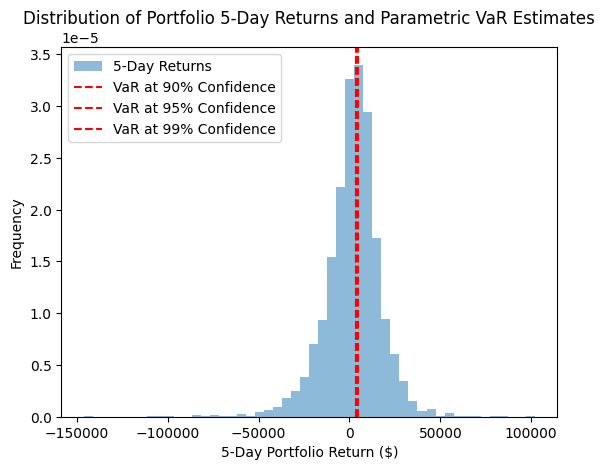

In [ ]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()